## MSDS AI Capstone: Visual QUestion Answering on Chart Data
<div class="alert alert-block alert-success">
    <b>More Technical</b>: Throughout the notebook. This types of boxes provide more technical details and extra references about what you are seeing. They contain helpful tips, but you can safely skip them the first time you run through the code.
</div><br>

Images in the FigureQA dataset are comprised on five types of figures commonly found in analytical documents. Fifteen question types were selected for the dataset concerning quantitative attributes in relational global and one-vs-one contexts. These include properties like minimum and maximum, greater and less than, medians, curve roughness, and area under the curve (AUC). All questions in the training and validation sets have either a yes or no answer.

<div class="alert alert-block alert-info">
<b>The FigureQA dataset</b><br>
https://www.microsoft.com/en-us/research/project/figureqa-dataset/
    </div>

## Verify TensorFlow Version and Keras Version

In [ ]:
#downgrade tensorflow version so keras can be stable (he latets version which is 2.14.0 was not working well with keras - we should use 2.12.0)
#uncomment lines below to do so, then restart the run timee after and comemnt it out before re running this cell
#!pip install tensorflow==2.12.0 --ignore-installed --user

import tensorflow as tf

print("TensorFlow version: ", tf.__version__)

TensorFlow version:  2.12.0


In [ ]:
#import keras
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

In [ ]:
print("Keras version: ", tf.keras.__version__)

Keras version:  2.12.0


## Faster GPUs

Users who have purchased one of Colab's paid plans have access to premium GPUs. You can upgrade your notebook's GPU settings in `Runtime > Change runtime type` in the menu to enable Premium accelerator. Subject to availability, selecting a premium GPU may grant you access to a V100 or A100 Nvidia GPU.

The free of charge version of Colab grants access to Nvidia's T4 GPUs subject to quota restrictions and availability.

You can see what GPU you've been assigned at any time by executing the following cell. If the execution result of running the code cell below is "Not connected to a GPU", you can change the runtime by going to `Runtime > Change runtime type` in the menu to enable a GPU accelerator, and then re-execute the code cell.


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Nov 14 00:20:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In order to use a GPU with your notebook, select the `Runtime > Change runtime type` menu, and then set the hardware accelerator dropdown to GPU.

## Imports

In [ ]:
import numpy as np
import pandas as pd
from packaging import version

import os

from sklearn.manifold import TSNE

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

import nltk
nltk.download('punkt')
import re
import string
from nltk.tokenize import word_tokenize

import math
from itertools import permutations
from scipy.stats import rankdata

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
#package for OCR
!sudo apt install tesseract-ocr
!pip install pytesseract

#instal pytesseract
import pytesseract
import shutil
import imutils
import cv2
import os
import random
try:
 from PIL import Image
except ImportError:
 import Image

#if needed ot isntall to run code direcltly in jupyter notebook instead of google collab, follow thos instructiosn instead: https://stackoverflow.com/questions/50951955/pytesseract-tesseractnotfound-error-tesseract-is-not-installed-or-its-not-i

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 9 not upgraded.


In [ ]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

## Mount Google Cloud Sotrage Bucket to Colab Environment

Follow the isntructions here: https://colab.research.google.com/notebooks/snippets/gcs.ipynb#scrollTo=X0WH8rvDBtiG

Decided to use a GCP bucket instead of google drive because the train data has 100K images, which crashed the Google Drive mount in Colab


First, open run the following commands in a code block. The code will return a link for you to log in as a gmail user, and copy an verification code to authenticate yourself.

In [ ]:
from google.colab import auth

auth.authenticate_user()

project_id = 'msds-ai-capstone-chart-vqa'
!gcloud config set project {project_id}

Updated property [core/project].


You can use Cloud Storage FUSE to mount a Cloud Storage location to access it directly as a local filesystem path.

Run the following commands to install gcsfuse.

In [ ]:
# Install Cloud Storage FUSE.
!echo "deb https://packages.cloud.google.com/apt gcsfuse-`lsb_release -c -s` main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
!apt -qq update && apt -qq install gcsfuse

deb https://packages.cloud.google.com/apt gcsfuse-jammy main
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: apt-key is deprecated. Manage keyring files in trusted.gpg.d instead (see apt-key(8)).
100  2659  100  2659    0     0  29373      0 --:--:-- --:--:-- --:--:-- 29544
OK
9 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: https://packages.cloud.google.com/apt/dists/gcsfuse-jammy/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
gcsfuse is already the newest version (1.2.1).
0 upgraded, 0 newly installed, 0 to remove and 9 not upgraded.


In [ ]:
# Mount a Cloud Storage bucket or location, without the gs:// prefix.
mount_path = "dynamic-chart-vqa-train-data"  # or a location like "my-bucket/path/to/mount"
local_path = f"/mnt/gs/{mount_path}"

!mkdir -p {local_path}
!gcsfuse --implicit-dirs {mount_path} {local_path}

{"time":"17/11/2023 09:39:24.337085","severity":"INFO","msg":"Start gcsfuse/1.2.1 (Go version go1.21.3) for app \"\" using mount point: /mnt/gs/dynamic-chart-vqa-train-data\n"}


In [ ]:
# Then you can access it like a local path.
!ls -lh {local_path}

total 98M
drwxr-xr-x 1 root root   0 Nov 17 21:39 configs
drwxr-xr-x 1 root root   0 Nov 17 21:39 experiments
drwxr-xr-x 1 root root   0 Nov 17 21:39 models
-rw-r--r-- 1 root root 98M Jan 16  2021 pretrained.tar.gz
drwxr-xr-x 1 root root   0 Nov 17 21:39 sample_train1
drwxr-xr-x 1 root root   0 Nov 17 21:39 test
drwxr-xr-x 1 root root   0 Nov 17 21:39 train1
drwxr-xr-x 1 root root   0 Nov 17 21:39 validation1


## Import the Trainign and Validation Data generated from the 'Part 1' notebook

In [ ]:
import json

In [ ]:
# training data
# Change working directory to the GCS mount
os.chdir('/mnt/gs/dynamic-chart-vqa-train-data/train1')


with open('train_chart_type.json') as f:
    train_chart_type = np.asarray(json.load(f))

with open('train_image_fnames_unique.json') as f:
    train_image_fnames_unique = np.asarray(json.load(f))

In [ ]:
# training data
# Change working directory to the GCS mount
os.chdir('/mnt/gs/dynamic-chart-vqa-train-data/validation1')


with open('val_chart_type.json') as f:
    val_chart_type = np.asarray(json.load(f))

with open('val_image_fnames_unique.json') as f:
    val_image_fnames_unique = np.asarray(json.load(f))

### Encoding the target labels

In [ ]:
#before:

print(train_chart_type)

['vbar_categorical' 'vbar_categorical' 'hbar_categorical' ... 'dot_line'
 'line' 'dot_line']


In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
train_chart_label = encoder.fit_transform(train_chart_type)

#after:
print(train_chart_label)

[4 4 1 ... 0 2 0]


In [ ]:
print(val_chart_type)

['vbar_categorical' 'hbar_categorical' 'vbar_categorical' ... 'pie' 'line'
 'pie']


In [ ]:
val_chart_label = encoder.transform(val_chart_type)
print(val_chart_label)

[4 1 4 ... 3 2 3]


### Shuffling the training filename and labels

In [ ]:
import numpy as np

def shuffle_arrays(arrays, set_seed=-1):
    """Shuffles arrays in-place, in the same order, along axis=0

    Parameters:
    -----------
    arrays : List of NumPy arrays.
    set_seed : Seed value if int >= 0, else seed is random.
    """
    assert all(len(arr) == len(arrays[0]) for arr in arrays)
    seed = np.random.randint(0, 2**(32 - 1) - 1) if set_seed < 0 else set_seed

    for arr in arrays:
        rstate = np.random.RandomState(seed)
        rstate.shuffle(arr)

In [ ]:
shuffle_arrays([train_image_fnames_unique, train_chart_label],set_seed=100)
#shuffling bith the filename and the labels together!

In [ ]:
#chech it's been shuffled
train_image_fnames_unique

array(['22422.png', '25747.png', '13795.png', ..., '79683.png',
       '56088.png', '38408.png'], dtype='<U9')

In [ ]:
train_chart_label

array([1, 1, 4, ..., 0, 1, 4])

### processing the images and batching the dataset

In [ ]:
BATCH_SIZE=64
IMG_SIZE=(128,128)
image_pad_size=[128, 128]

os.chdir('/')

#Function to load and decode the image from the file paths in the dataframe and use the encoder function
def preprocess_train(im,ans):
    im=tf.io.read_file('/mnt/gs/dynamic-chart-vqa-train-data/train1/png/' + im)
    im=tf.image.decode_png(im,channels=3)
    h, w = tf.unstack(tf.cast(tf.shape(im)[:2], tf.float32))
    target_h, target_w = IMG_SIZE
    aspect_ratio = w / h
    w_ratio = target_w / w
    h_ratio = target_h / h
    target_aspect_ratio = float(target_w) / target_h
    im = tf.cond(tf.greater(aspect_ratio, target_aspect_ratio),
                 lambda: tf.image.resize(
                    im, size=(tf.cast(w_ratio * h, tf.int32),
                              tf.cast(target_w, tf.int32))
                    ),
                 lambda: tf.image.resize(
                    im, size=(tf.cast(target_h, tf.int32),
                              tf.cast(h_ratio * w, tf.int32))
                    )
                 )
    im = tf.image.resize_with_crop_or_pad(
        im, target_height=target_h, target_width=target_w
        )
    im.set_shape((target_h, target_w, 3))#Explicit shape must be defined in order to create the Input pipeline
    im = im / 255.
    #ans.set_shape([1])#Explicit shape must be defined in order to create the Input pipeline

    return im,ans

def create_pipeline_train(image_fnames,encoded_answers):
    raw_df=tf.data.Dataset.from_tensor_slices(((image_fnames),encoded_answers))
    df=raw_df.map(preprocess_train)#Preprocessing function is applied to the dataset
    #df = df.shuffle(buffer_size=len(image_fnames)) #make sure the buffer_size is euqal to the training dataset size, since the images are organized by chart type and we want to make sure we shufle at random across the entire dataset
    df=df.batch(BATCH_SIZE)#The dataset is batched
    return df

#The training Dataset object is created
train_dataset=create_pipeline_train(train_image_fnames_unique,train_chart_label)


In [ ]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
BATCH_SIZE=64
IMG_SIZE=(128,128)
image_pad_size=[128, 128]

os.chdir('/')

#Function to load and decode the image from the file paths in the dataframe and use the encoder function
def preprocess_train(im,ans):
    im=tf.io.read_file('/mnt/gs/dynamic-chart-vqa-train-data/validation1/png/' + im)
    im=tf.image.decode_png(im,channels=3)
    h, w = tf.unstack(tf.cast(tf.shape(im)[:2], tf.float32))
    target_h, target_w = IMG_SIZE
    aspect_ratio = w / h
    w_ratio = target_w / w
    h_ratio = target_h / h
    target_aspect_ratio = float(target_w) / target_h
    im = tf.cond(tf.greater(aspect_ratio, target_aspect_ratio),
                 lambda: tf.image.resize(
                    im, size=(tf.cast(w_ratio * h, tf.int32),
                              tf.cast(target_w, tf.int32))
                    ),
                 lambda: tf.image.resize(
                    im, size=(tf.cast(target_h, tf.int32),
                              tf.cast(h_ratio * w, tf.int32))
                    )
                 )
    im = tf.image.resize_with_crop_or_pad(
        im, target_height=target_h, target_width=target_w
        )
    im.set_shape((target_h, target_w, 3))#Explicit shape must be defined in order to create the Input pipeline
    im = im / 255.
    #ans.set_shape([1])#Explicit shape must be defined in order to create the Input pipeline

    return im,ans

def create_pipeline_train(image_fnames,encoded_answers):
    raw_df=tf.data.Dataset.from_tensor_slices(((image_fnames),encoded_answers))
    df=raw_df.map(preprocess_train)#Preprocessing function is applied to the dataset
    df=df.batch(BATCH_SIZE)#The dataset is batched
    return df

#The training Dataset object is created
val_dataset=create_pipeline_train(val_image_fnames_unique,val_chart_label)


In [ ]:
val_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
#check the way the dataset is build (interrupt the cell run when needed)
for e in val_dataset:
    print (e)

(<tf.Tensor: shape=(64, 128, 128, 3), dtype=float32, numpy=
array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]],




KeyboardInterrupt: ignored

# Build Model

In [ ]:
#build the model

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D


NUMBER_CLASS = 5
INPUT_SHAPE = (128,128,3)

model_simple = Sequential([
    Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=INPUT_SHAPE),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=NUMBER_CLASS, activation='softmax')
])

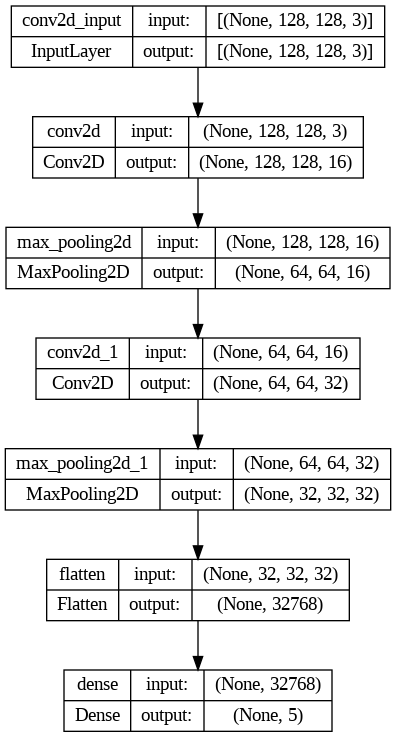

In [ ]:
keras.utils.plot_model(model_simple, "chart_type_prediction_model.png", show_shapes=True)

In [ ]:
model_simple.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 5)                 1

# Utility Functions

In [ ]:
from keras.optimizers import Adam

def compile_train_model(model, train_dataset, validation_dataset, checkpoint_path, epochs=10):
  timestamp=int(time.time())

  # Compile
  model.compile(optimizer=Adam(learning_rate=0.0001),
                loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])
  # Train
  start_time = time.time()
  history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=validation_dataset,
    #verbose=0,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_best_only=True,save_weights_only=False)
        ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
        ]
  )
  end_time = time.time()
  second_elapsed = round(end_time - start_time)

  print(f'Finished model training in {second_elapsed}s')

  print('Model performance with training set')
  model.evaluate(train_dataset)

  print('Evaluating model performance with validation set')
  model.evaluate(validation_dataset)

  return history, model

In [ ]:
def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

In [ ]:
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions))))

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

# Train the Model

In [ ]:
%%time


import datetime
import time

os.chdir('/')

#set up checkpoint Path
checkpoint_path = "/mnt/gs/dynamic-chart-vqa-train-data/models/chart_type_model_simple.h5"

# Compile and train
history_simple, model_simple = compile_train_model(model_simple,
                                     train_dataset,
                                     val_dataset,
                                     checkpoint_path,
                                     epochs = 10
                                    )

Epoch 1/10
1563/1563 [==============================] - 13027s 8s/step - loss: 0.2629 - accuracy: 0.9041 - val_loss: 0.0667 - val_accuracy: 0.9907
Epoch 2/10
1563/1563 [==============================] - 12793s 8s/step - loss: 0.0395 - accuracy: 0.9931 - val_loss: 0.0287 - val_accuracy: 0.9944
Epoch 3/10
1563/1563 [==============================] - 12682s 8s/step - loss: 0.0193 - accuracy: 0.9962 - val_loss: 0.0180 - val_accuracy: 0.9961
Epoch 4/10
1563/1563 [==============================] - 12743s 8s/step - loss: 0.0128 - accuracy: 0.9972 - val_loss: 0.0111 - val_accuracy: 0.9978
Epoch 5/10
1563/1563 [==============================] - 12684s 8s/step - loss: 0.0099 - accuracy: 0.9976 - val_loss: 0.0089 - val_accuracy: 0.9982
Epoch 6/10
1100/1563 [====================>.........] - ETA: 53:41 - loss: 0.0083 - accuracy: 0.9980

### Load H5 file of the best model epoch and Evaluate the model on the val dataset

<div class="alert alert-block alert-info">
<b>tf.keras.models.load_model</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model</div>

In order to ensure that this is not a simple "memorization" by the machine, we should evaluate the performance on the test set. This is easy to do, we simply use the `evaluate` method on our model.

In [ ]:
%%time

model_simple = tf.keras.models.load_model("/mnt/gs/dynamic-chart-vqa-train-data/models/chart_type_model_simple.h5")
print(f"Val acc: {model_simple.evaluate(val_dataset)[1]:.3f}")

  9/313 [..............................] - ETA: 35:59 - loss: 0.0099 - accuracy: 0.9965

KeyboardInterrupt: ignored

### Predictions on the val dataset

In [ ]:
#creating a batched dataset with just the validation images batched (i.e. does not include the labels)

BATCH_SIZE=64
IMG_SIZE=(128,128)
image_pad_size=[128, 128]

os.chdir('/')

#Function to load and decode the image from the file paths in the dataframe and use the encoder function
def preprocess_images_only(im):
    im=tf.io.read_file('/mnt/gs/dynamic-chart-vqa-train-data/validation1/png/' + im)
    im=tf.image.decode_png(im,channels=3)
    h, w = tf.unstack(tf.cast(tf.shape(im)[:2], tf.float32))
    target_h, target_w = IMG_SIZE
    aspect_ratio = w / h
    w_ratio = target_w / w
    h_ratio = target_h / h
    target_aspect_ratio = float(target_w) / target_h
    im = tf.cond(tf.greater(aspect_ratio, target_aspect_ratio),
                 lambda: tf.image.resize(
                    im, size=(tf.cast(w_ratio * h, tf.int32),
                              tf.cast(target_w, tf.int32))
                    ),
                 lambda: tf.image.resize(
                    im, size=(tf.cast(target_h, tf.int32),
                              tf.cast(h_ratio * w, tf.int32))
                    )
                 )
    im = tf.image.resize_with_crop_or_pad(
        im, target_height=target_h, target_width=target_w
        )
    im.set_shape((target_h, target_w, 3))#Explicit shape must be defined in order to create the Input pipeline
    im = im / 255.
    #ans.set_shape([1])#Explicit shape must be defined in order to create the Input pipeline

    return im

def preprocess_images(image_fnames):
    raw_df=tf.data.Dataset.from_tensor_slices((image_fnames))
    df=raw_df.map(preprocess_images_only)#Preprocessing function is applied to the dataset
    df=df.batch(BATCH_SIZE)#The dataset is batched
    return df

#The training Dataset object is created
val_images=preprocess_images(val_image_fnames_unique)


In [ ]:
val_images

<_BatchDataset element_spec=TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None)>

In [ ]:
model_simple.compile(optimizer=Adam(learning_rate=0.0001),
                loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])

In [ ]:
preds = model_simple.predict(val_images)
print('shape of preds: ', preds.shape)

313/313 [==============================] - 2191s 7s/step
shape of preds:  (20000, 5)


In [ ]:
preds

array([[0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

### Confusion matrices on val data
Using both `sklearn.metrics`. Then we visualize the confusion matrix and see what that tells us.

In [ ]:
pred=np.argmax(preds, axis=1) #only retain the predicted class with the highest probability for each observation in the test dataset

In [ ]:
pred

array([4, 1, 4, ..., 3, 2, 3])

In [ ]:
print_validation_report(val_chart_label, pred)

Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4000
           1       1.00      1.00      1.00      4000
           2       1.00      0.99      1.00      4000
           3       1.00      1.00      1.00      4000
           4       1.00      1.00      1.00      4000

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000

Accuracy Score: 0.9982
Root Mean Square Error: 0.08746427842267951


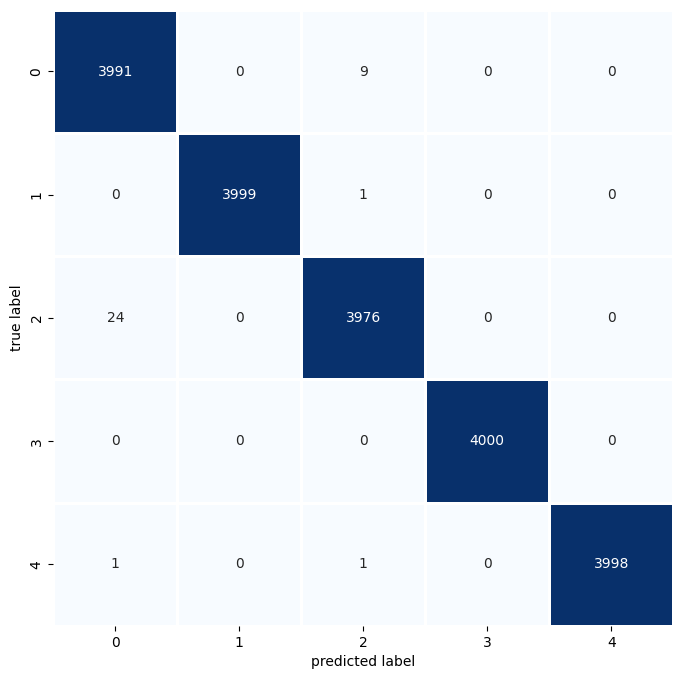

In [ ]:
plot_confusion_matrix(val_chart_label, pred)

### Visualize the convoluted features importance on a heatmap of a sample train image

In [ ]:
#load model weights

model_simple = tf.keras.models.load_model("/mnt/gs/dynamic-chart-vqa-train-data/models/chart_type_model_simple.h5")


following the instruction at this gthub: https://github.com/christianversloot/machine-learning-articles/blob/main/visualize-layer-outputs-of-your-keras-classifier-with-keract.md

In [ ]:
!pip install keract

#### Generating layer output visualizations



conv2d_input (1, 128, 128, 3) 


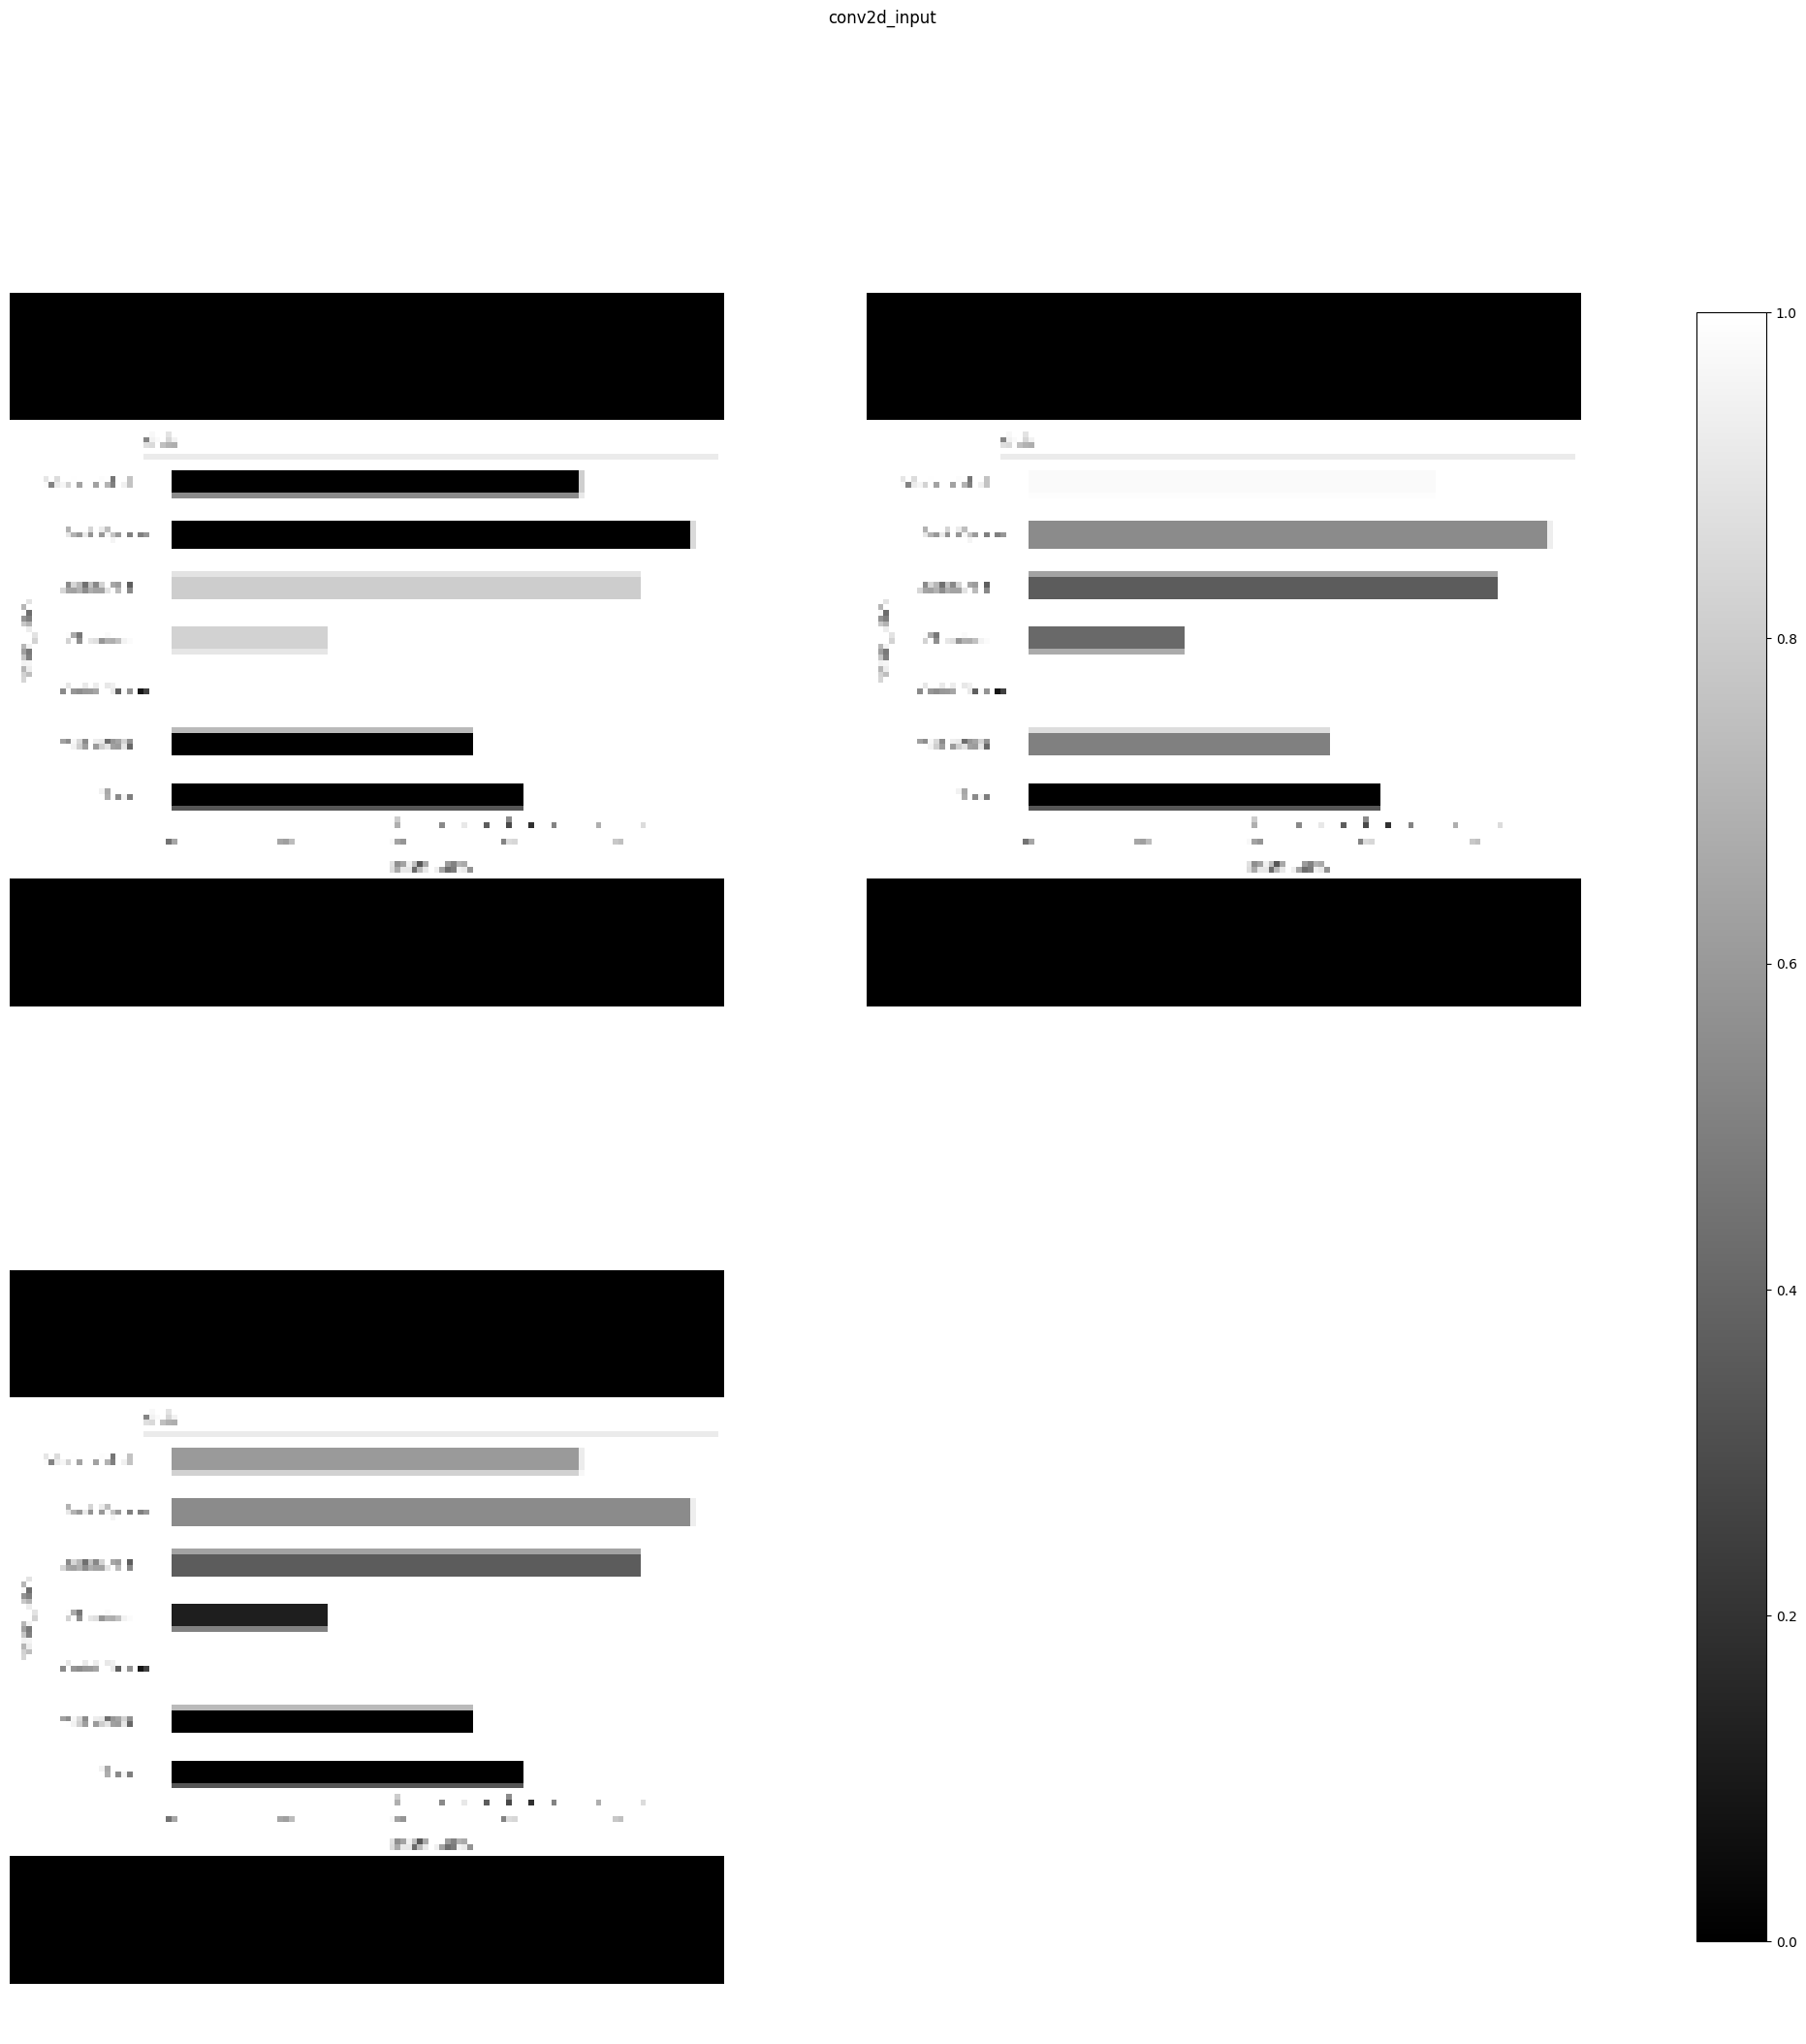

conv2d (1, 128, 128, 16) 


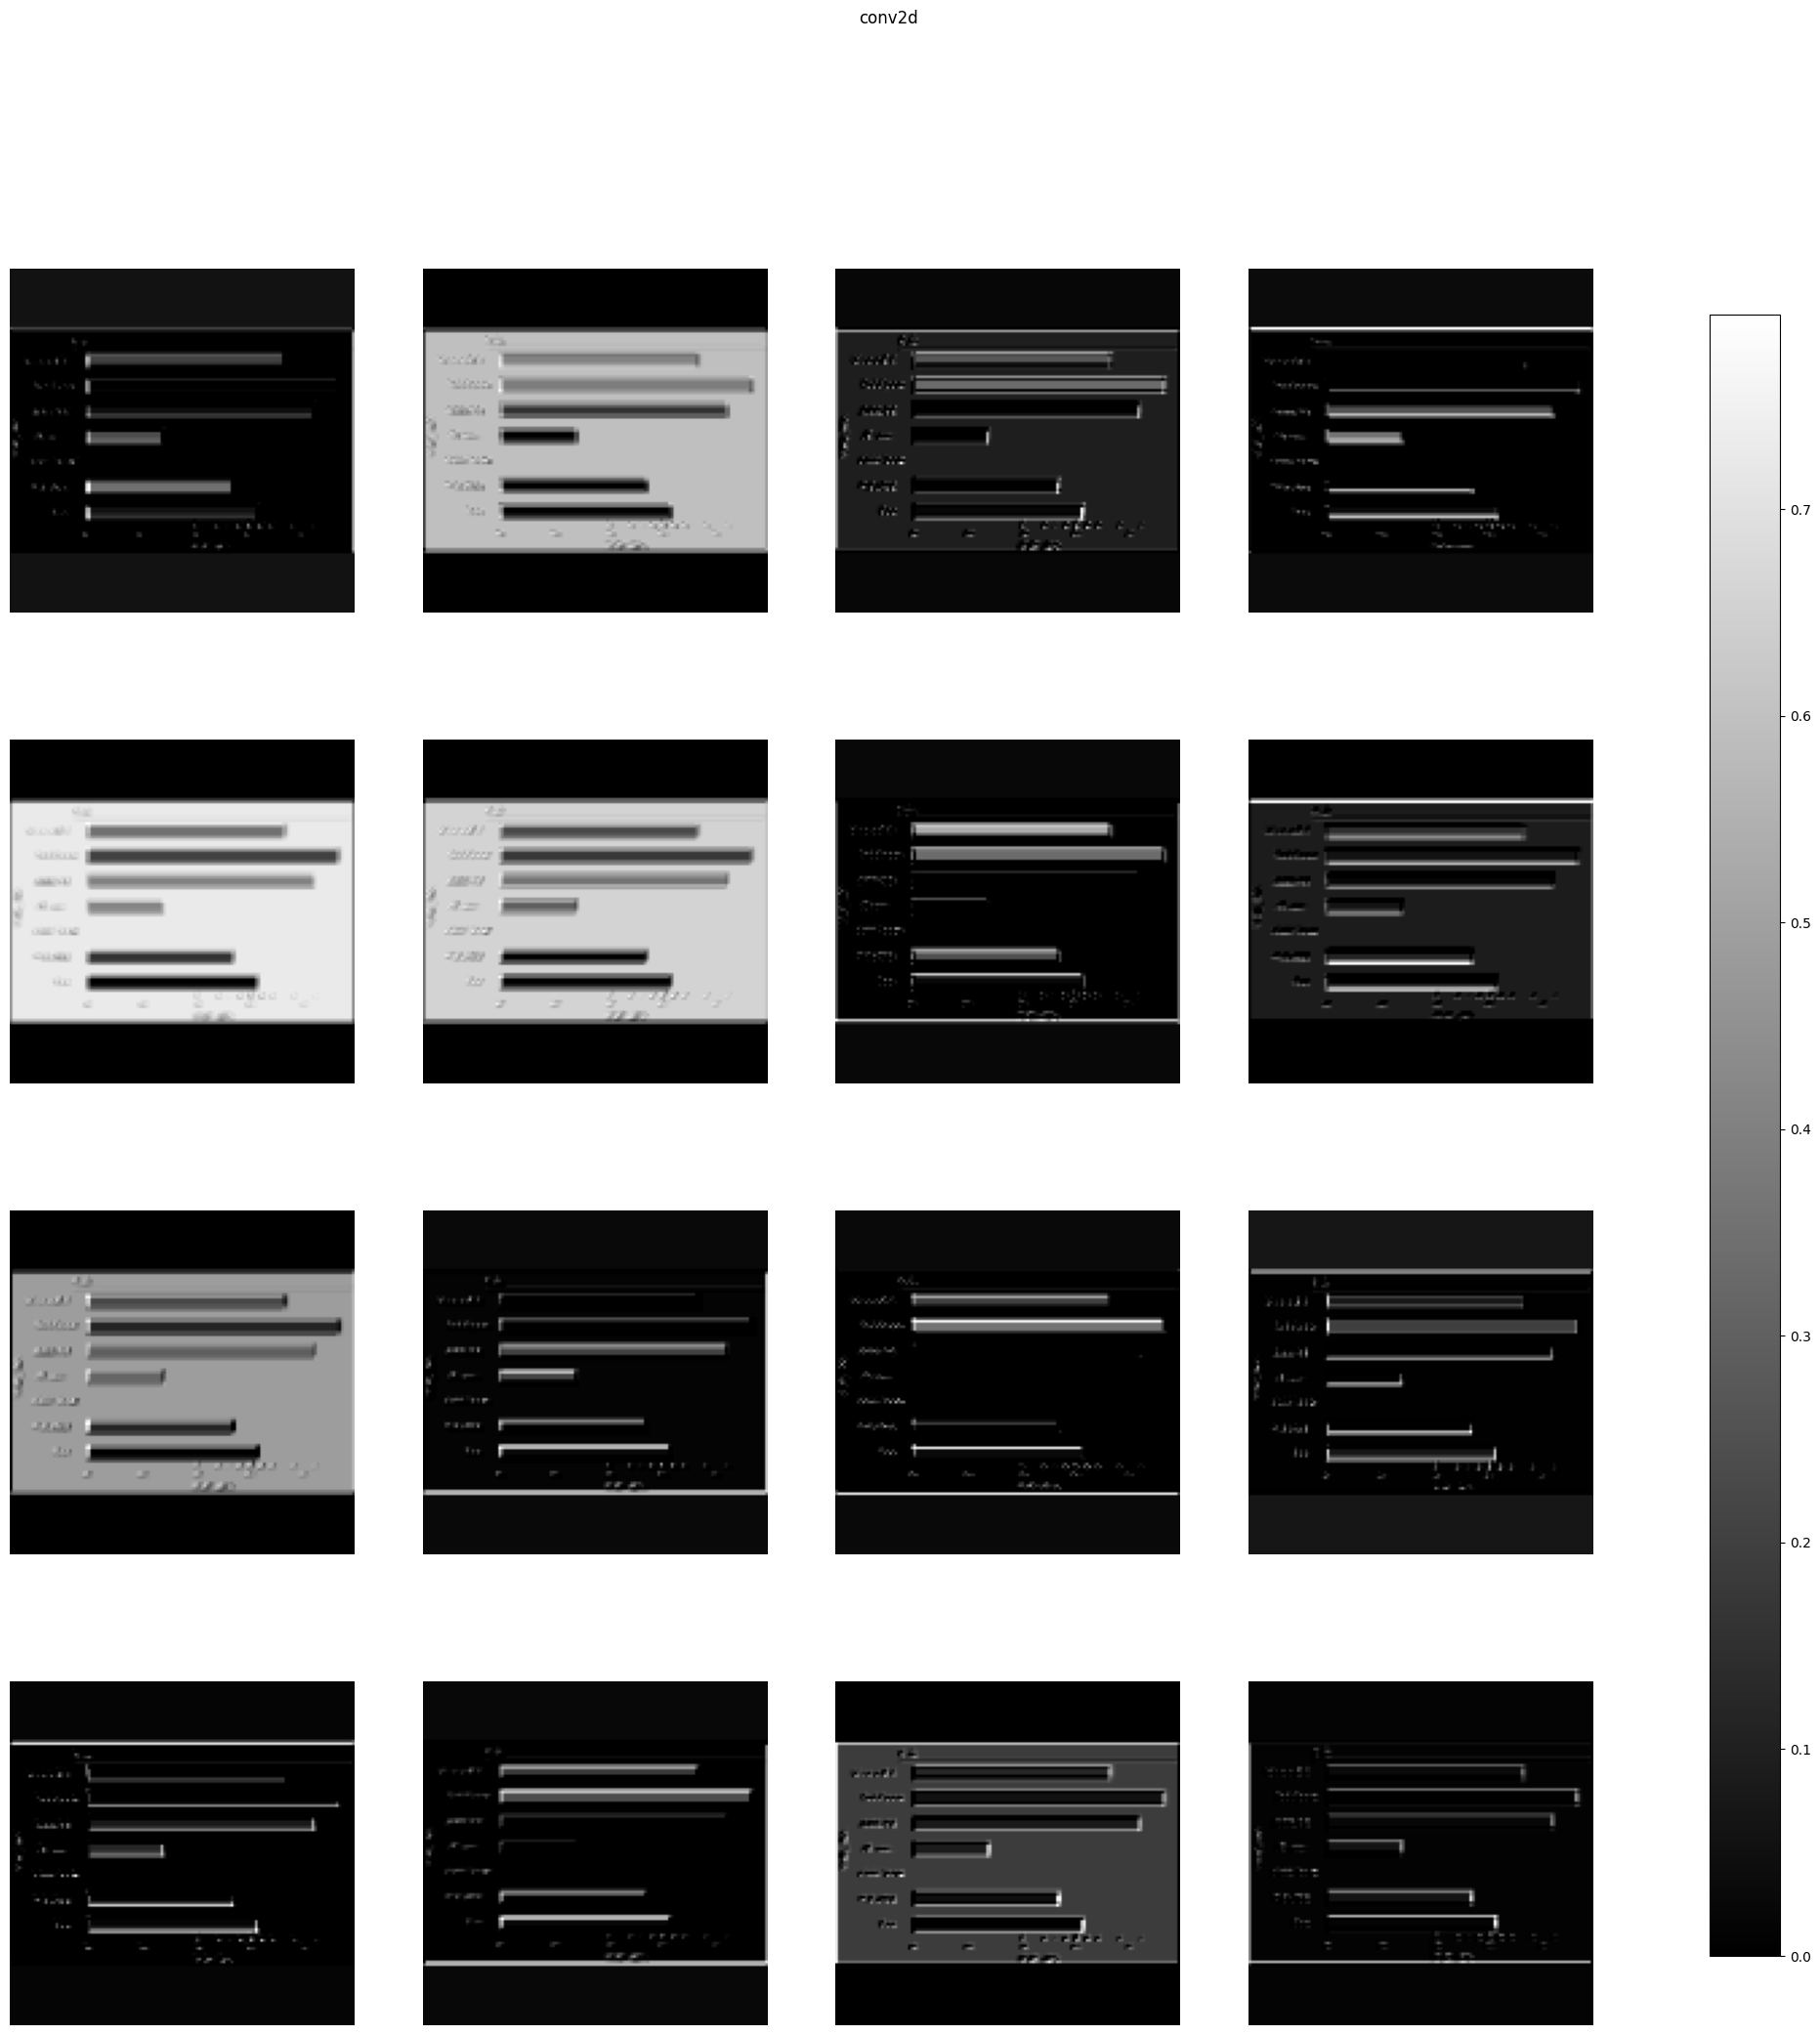

max_pooling2d (1, 64, 64, 16) 


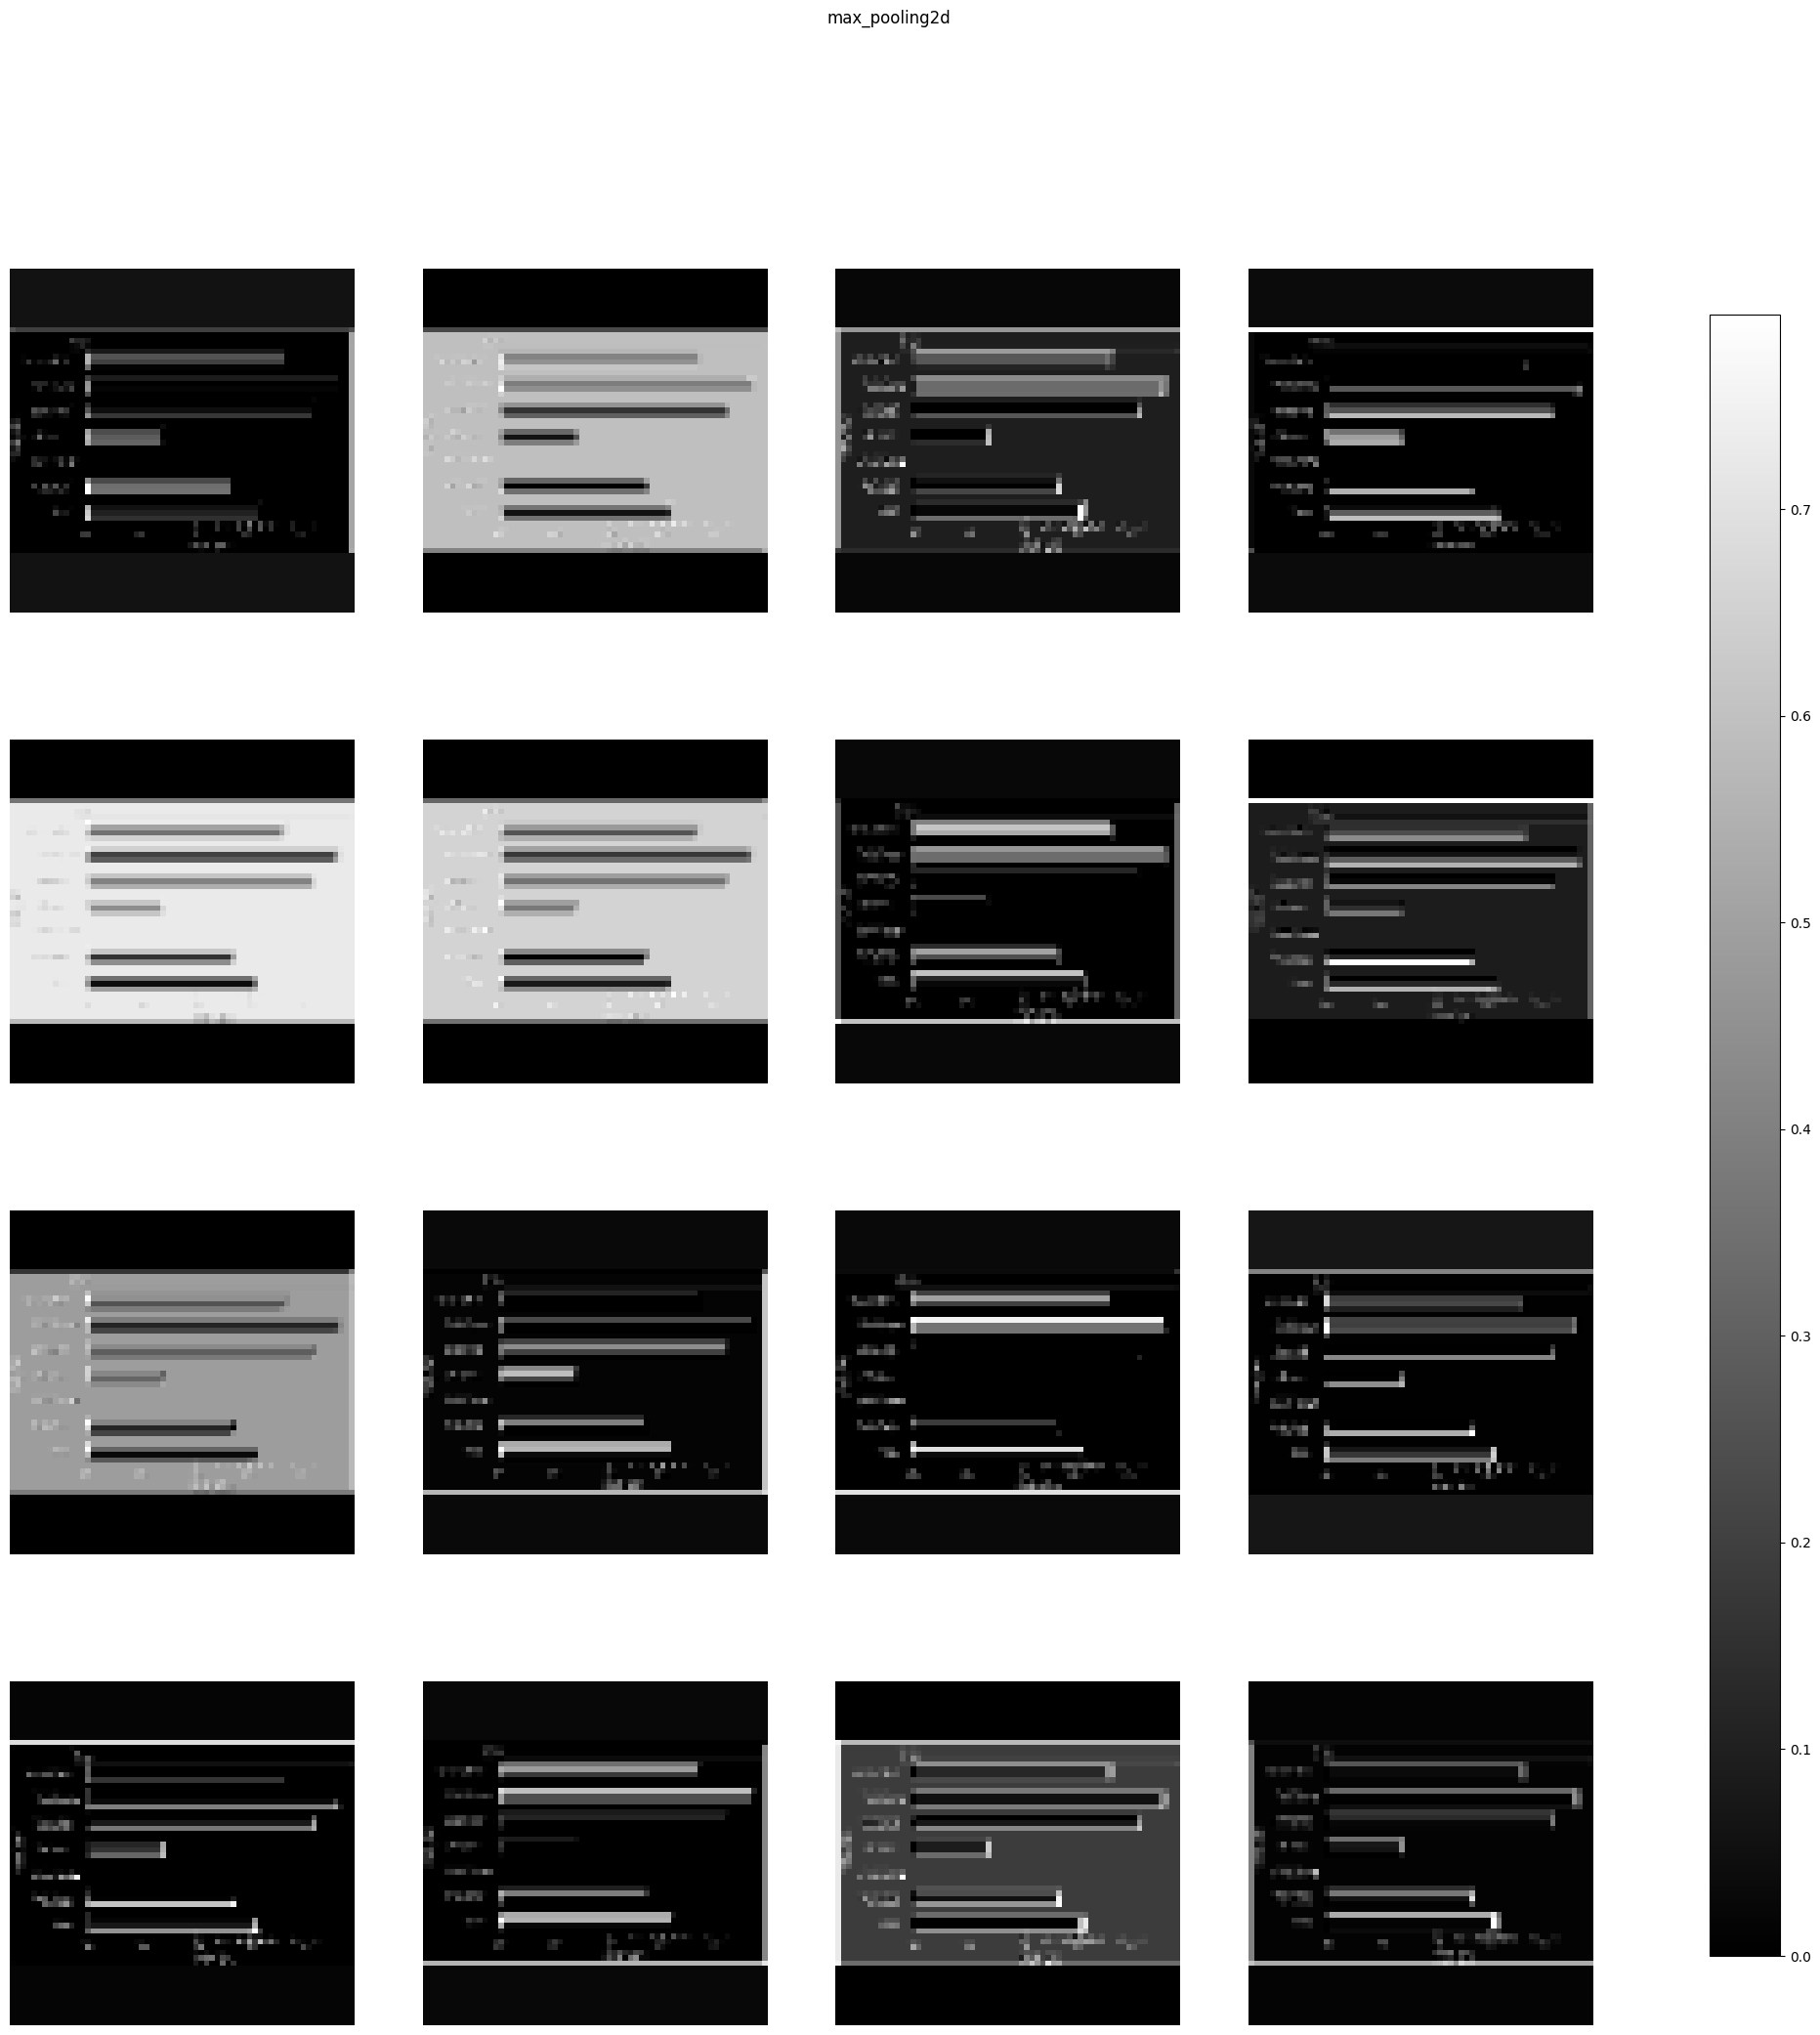

conv2d_1 (1, 64, 64, 32) 


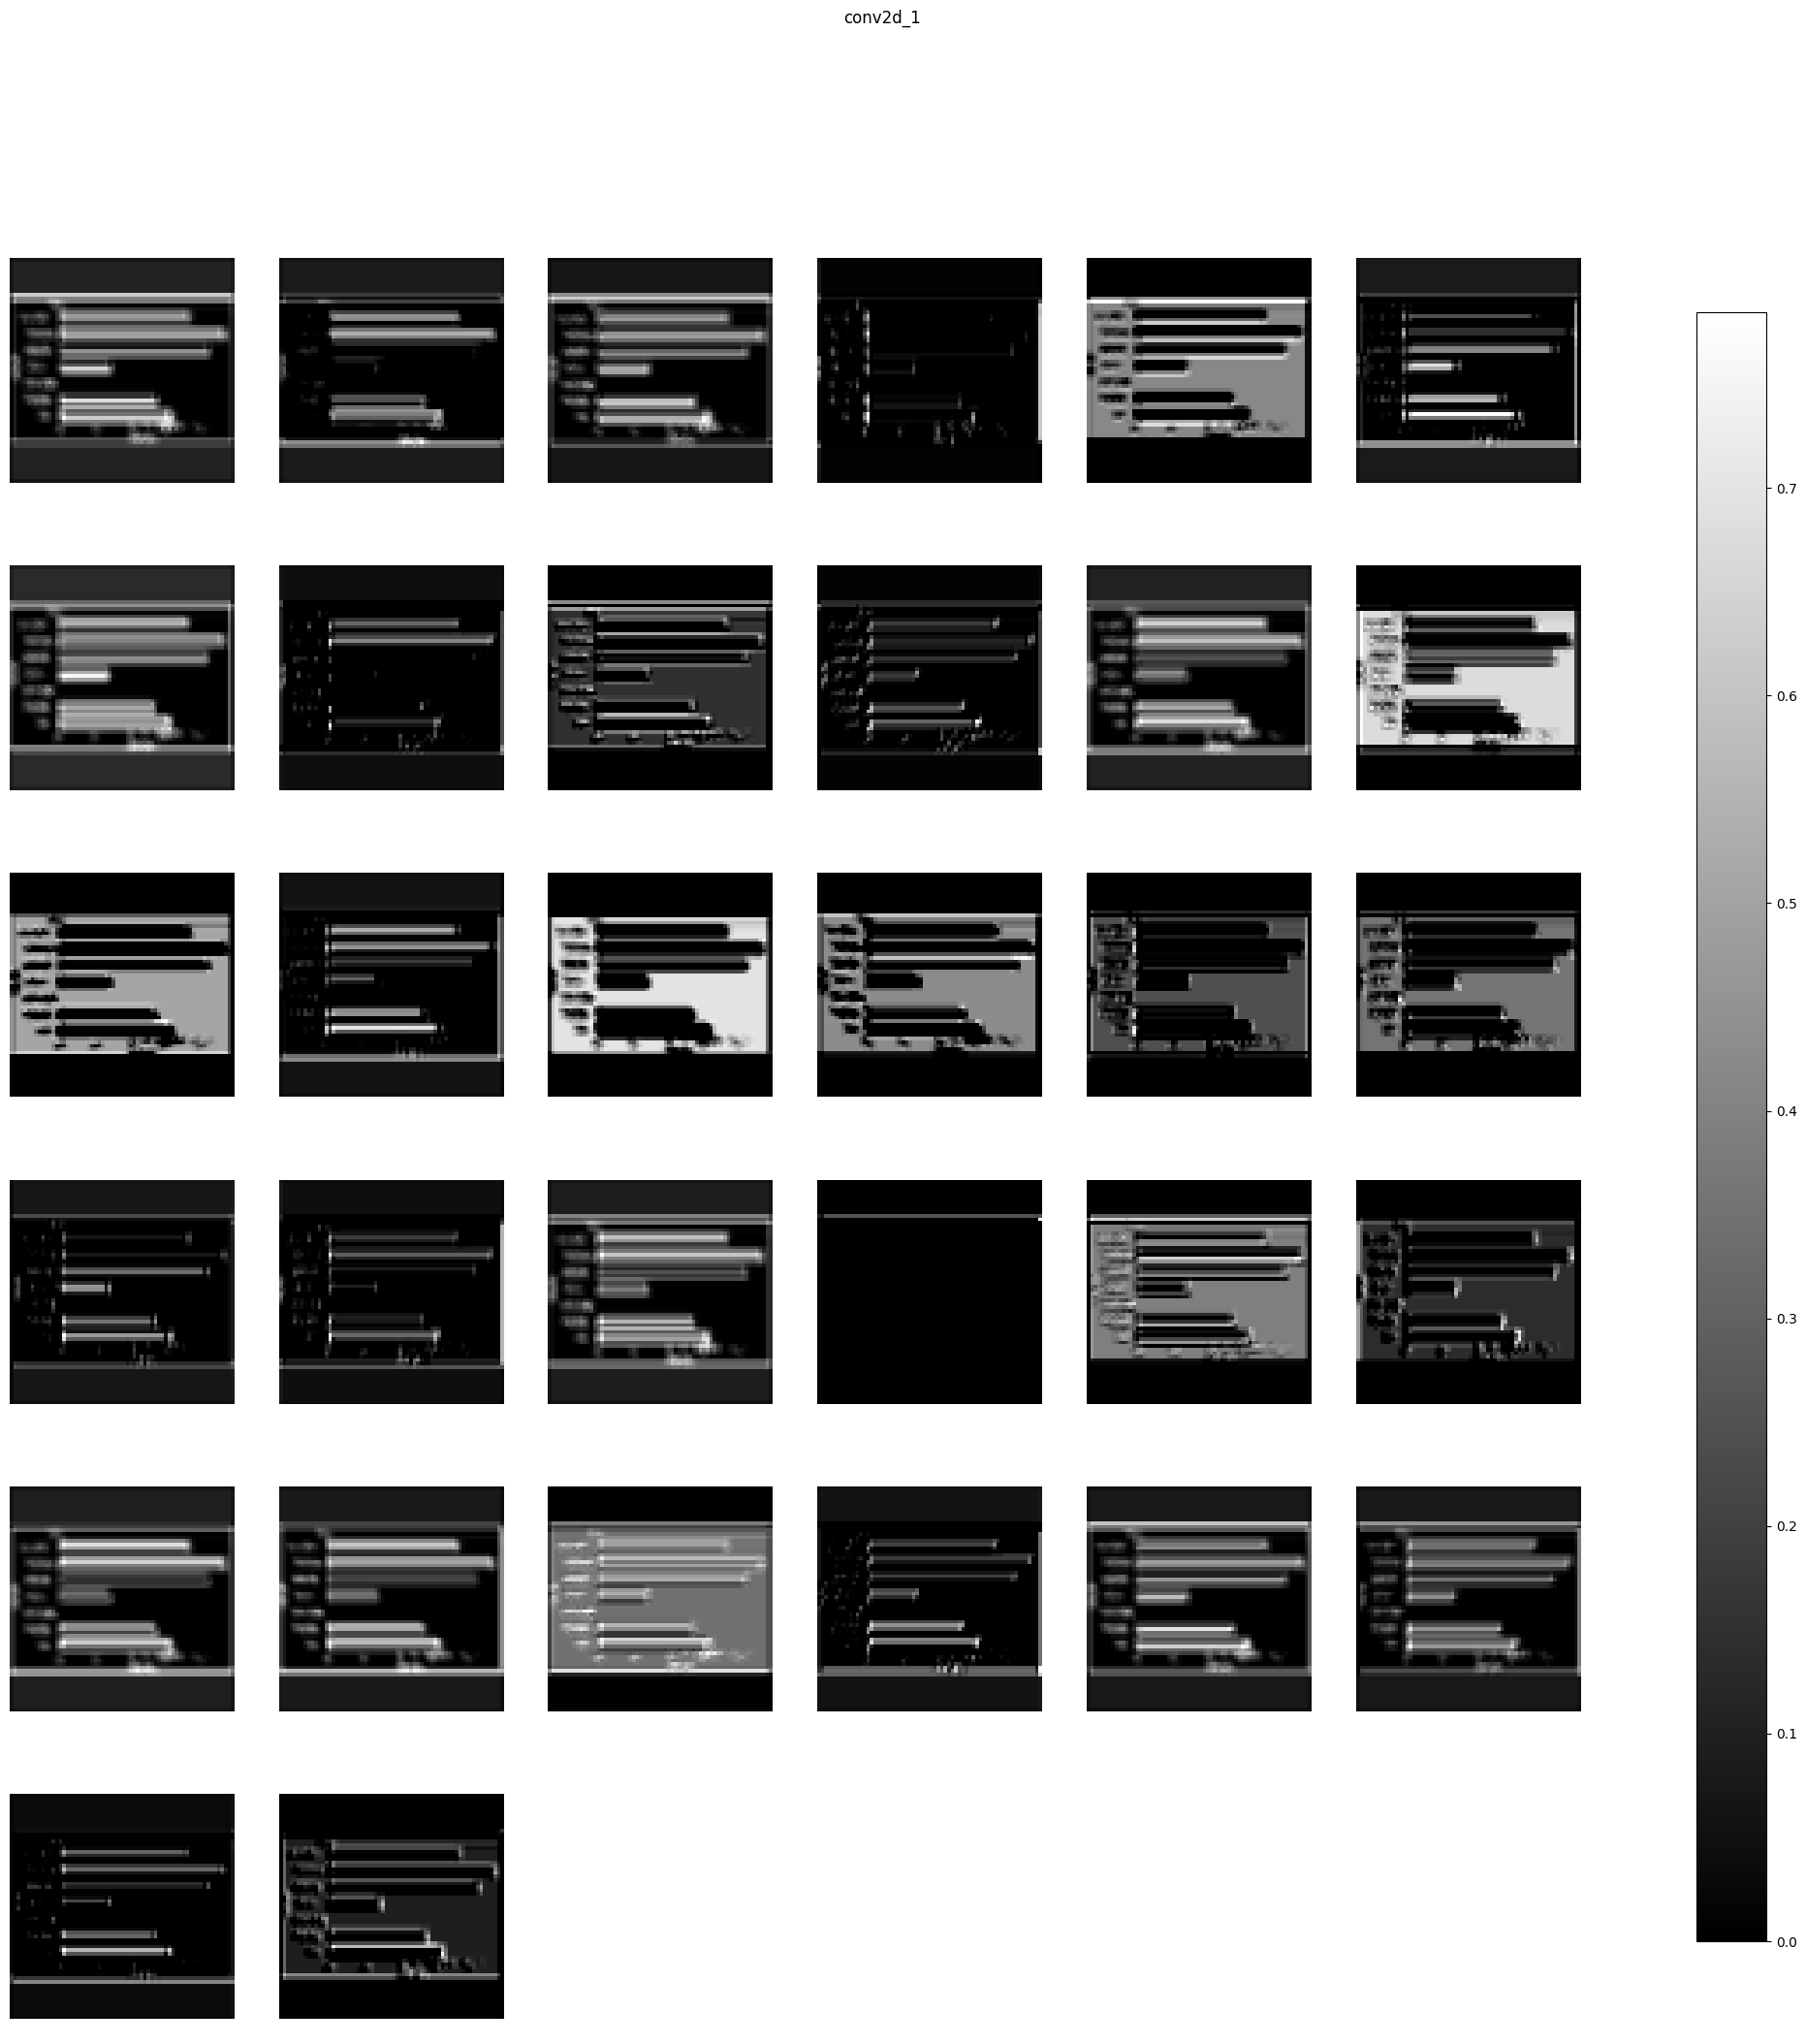

max_pooling2d_1 (1, 32, 32, 32) 


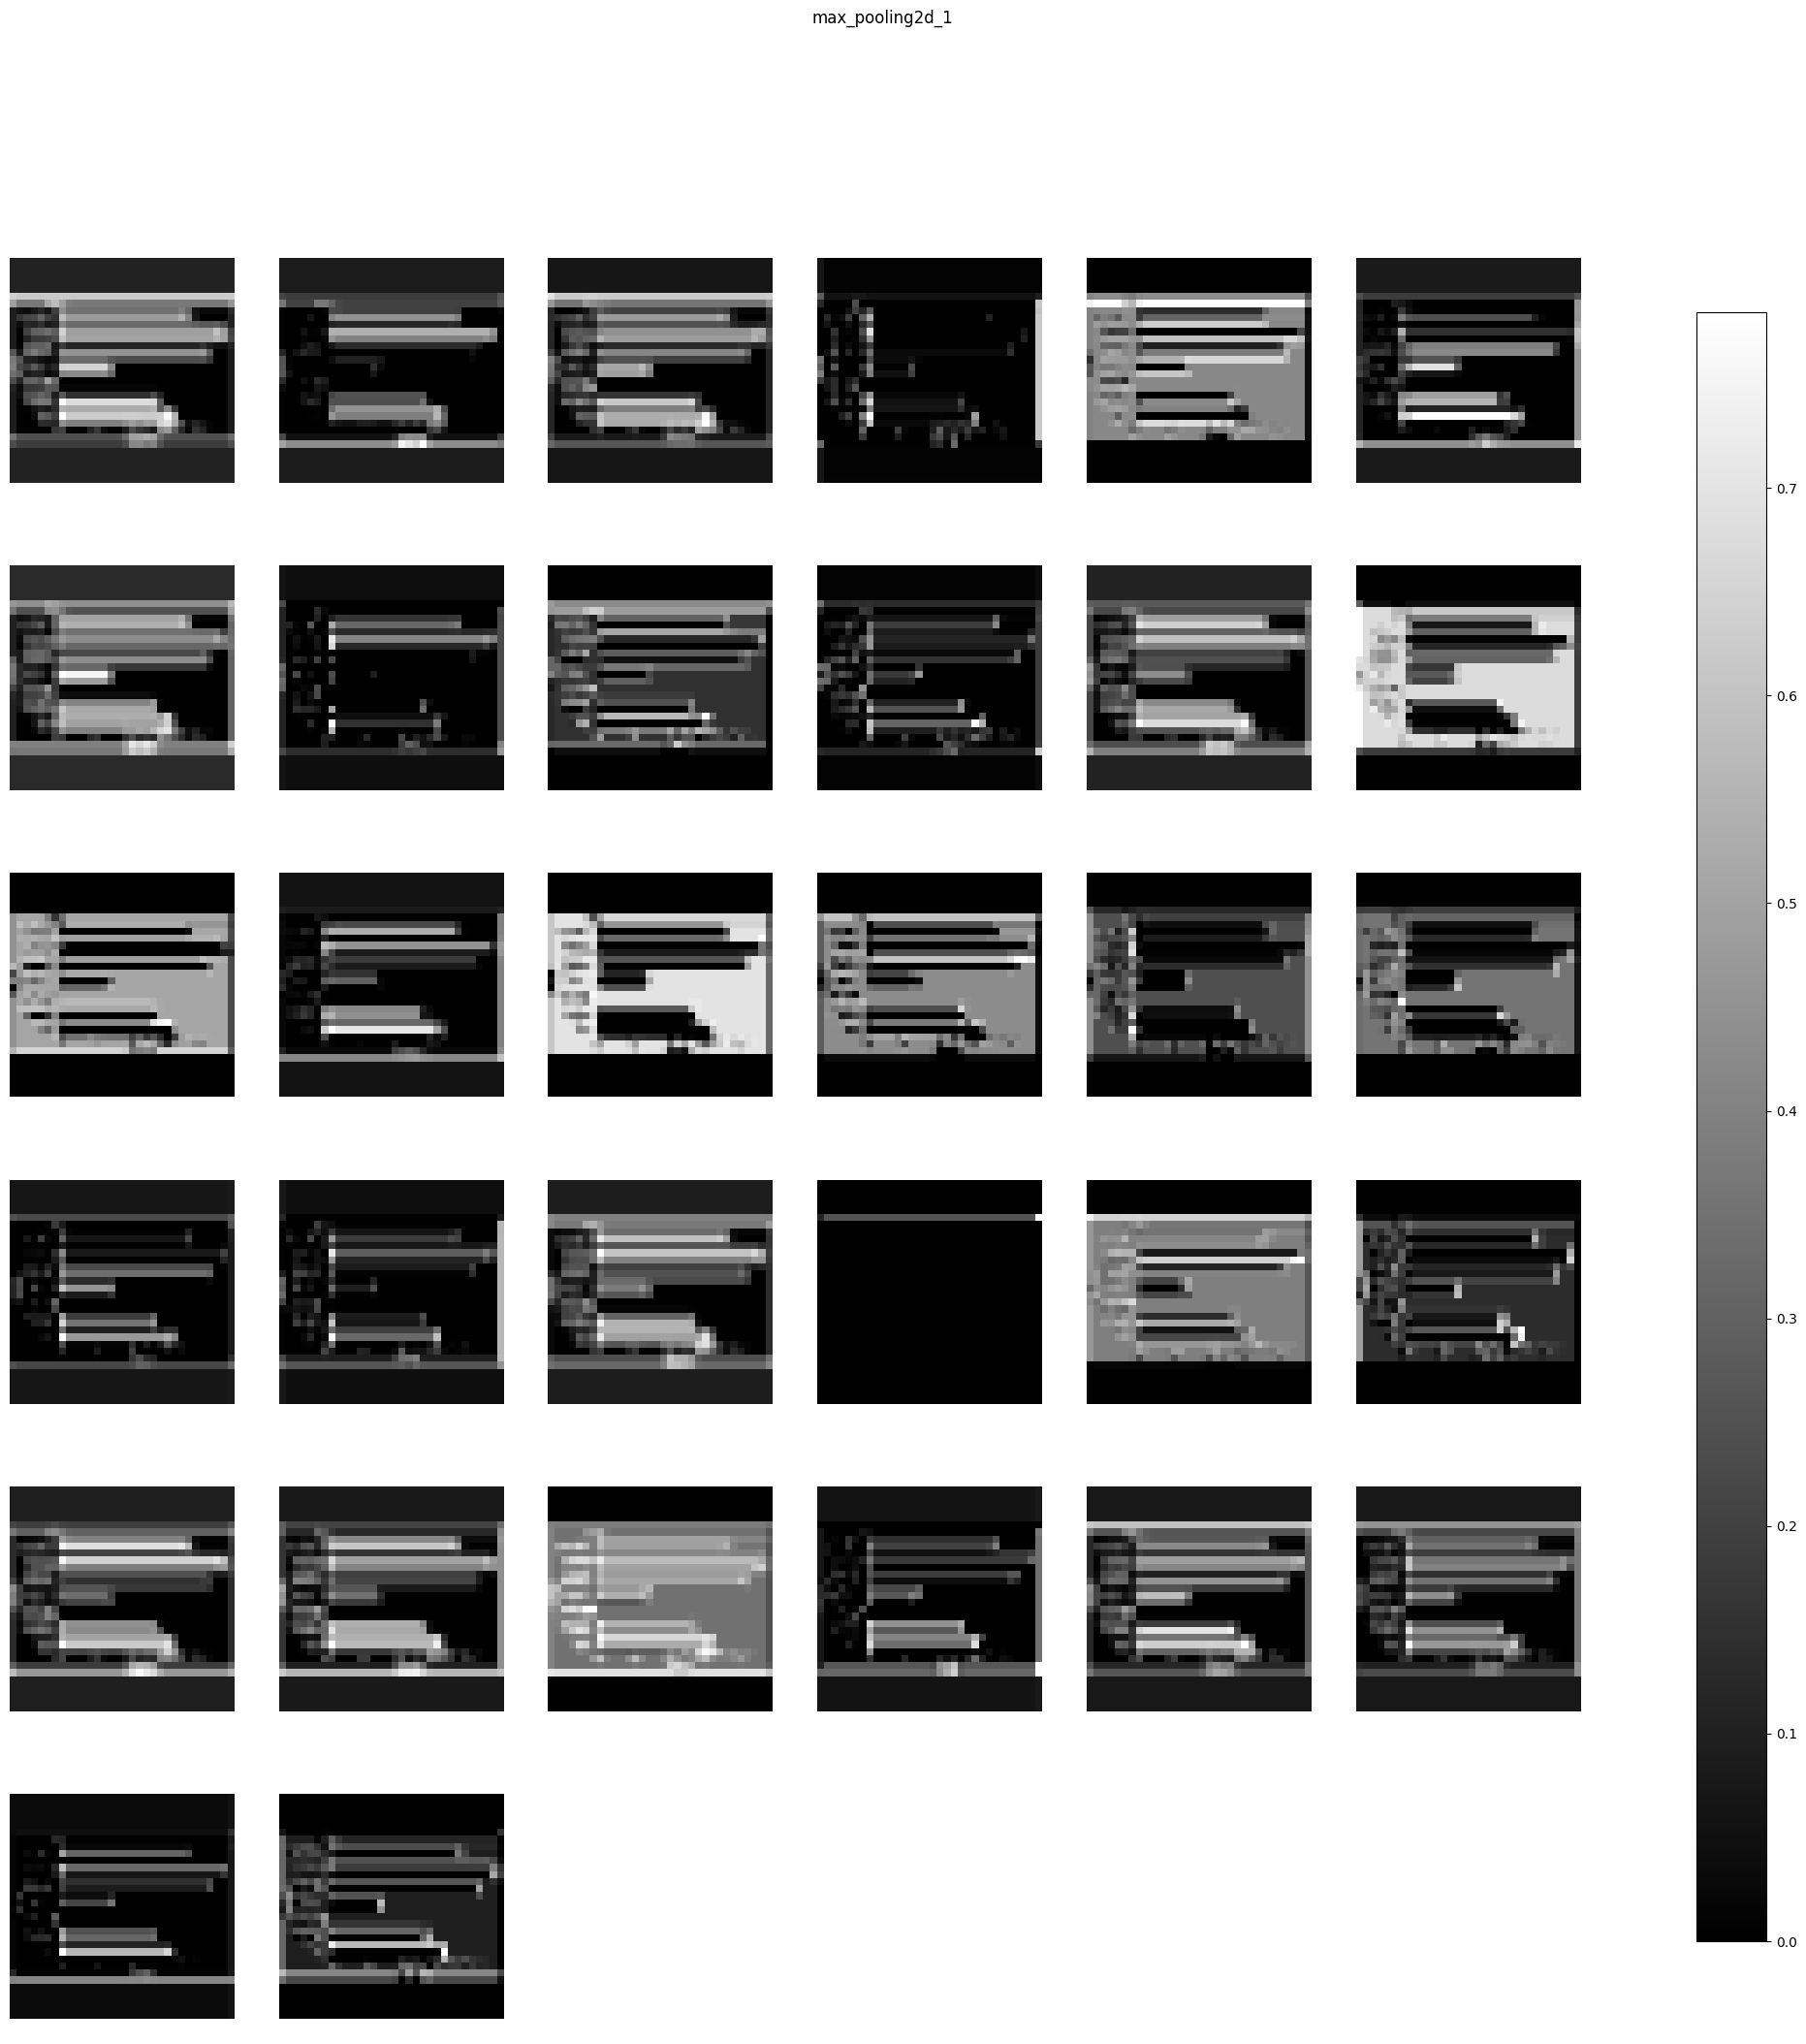

flatten (1, 32768) 


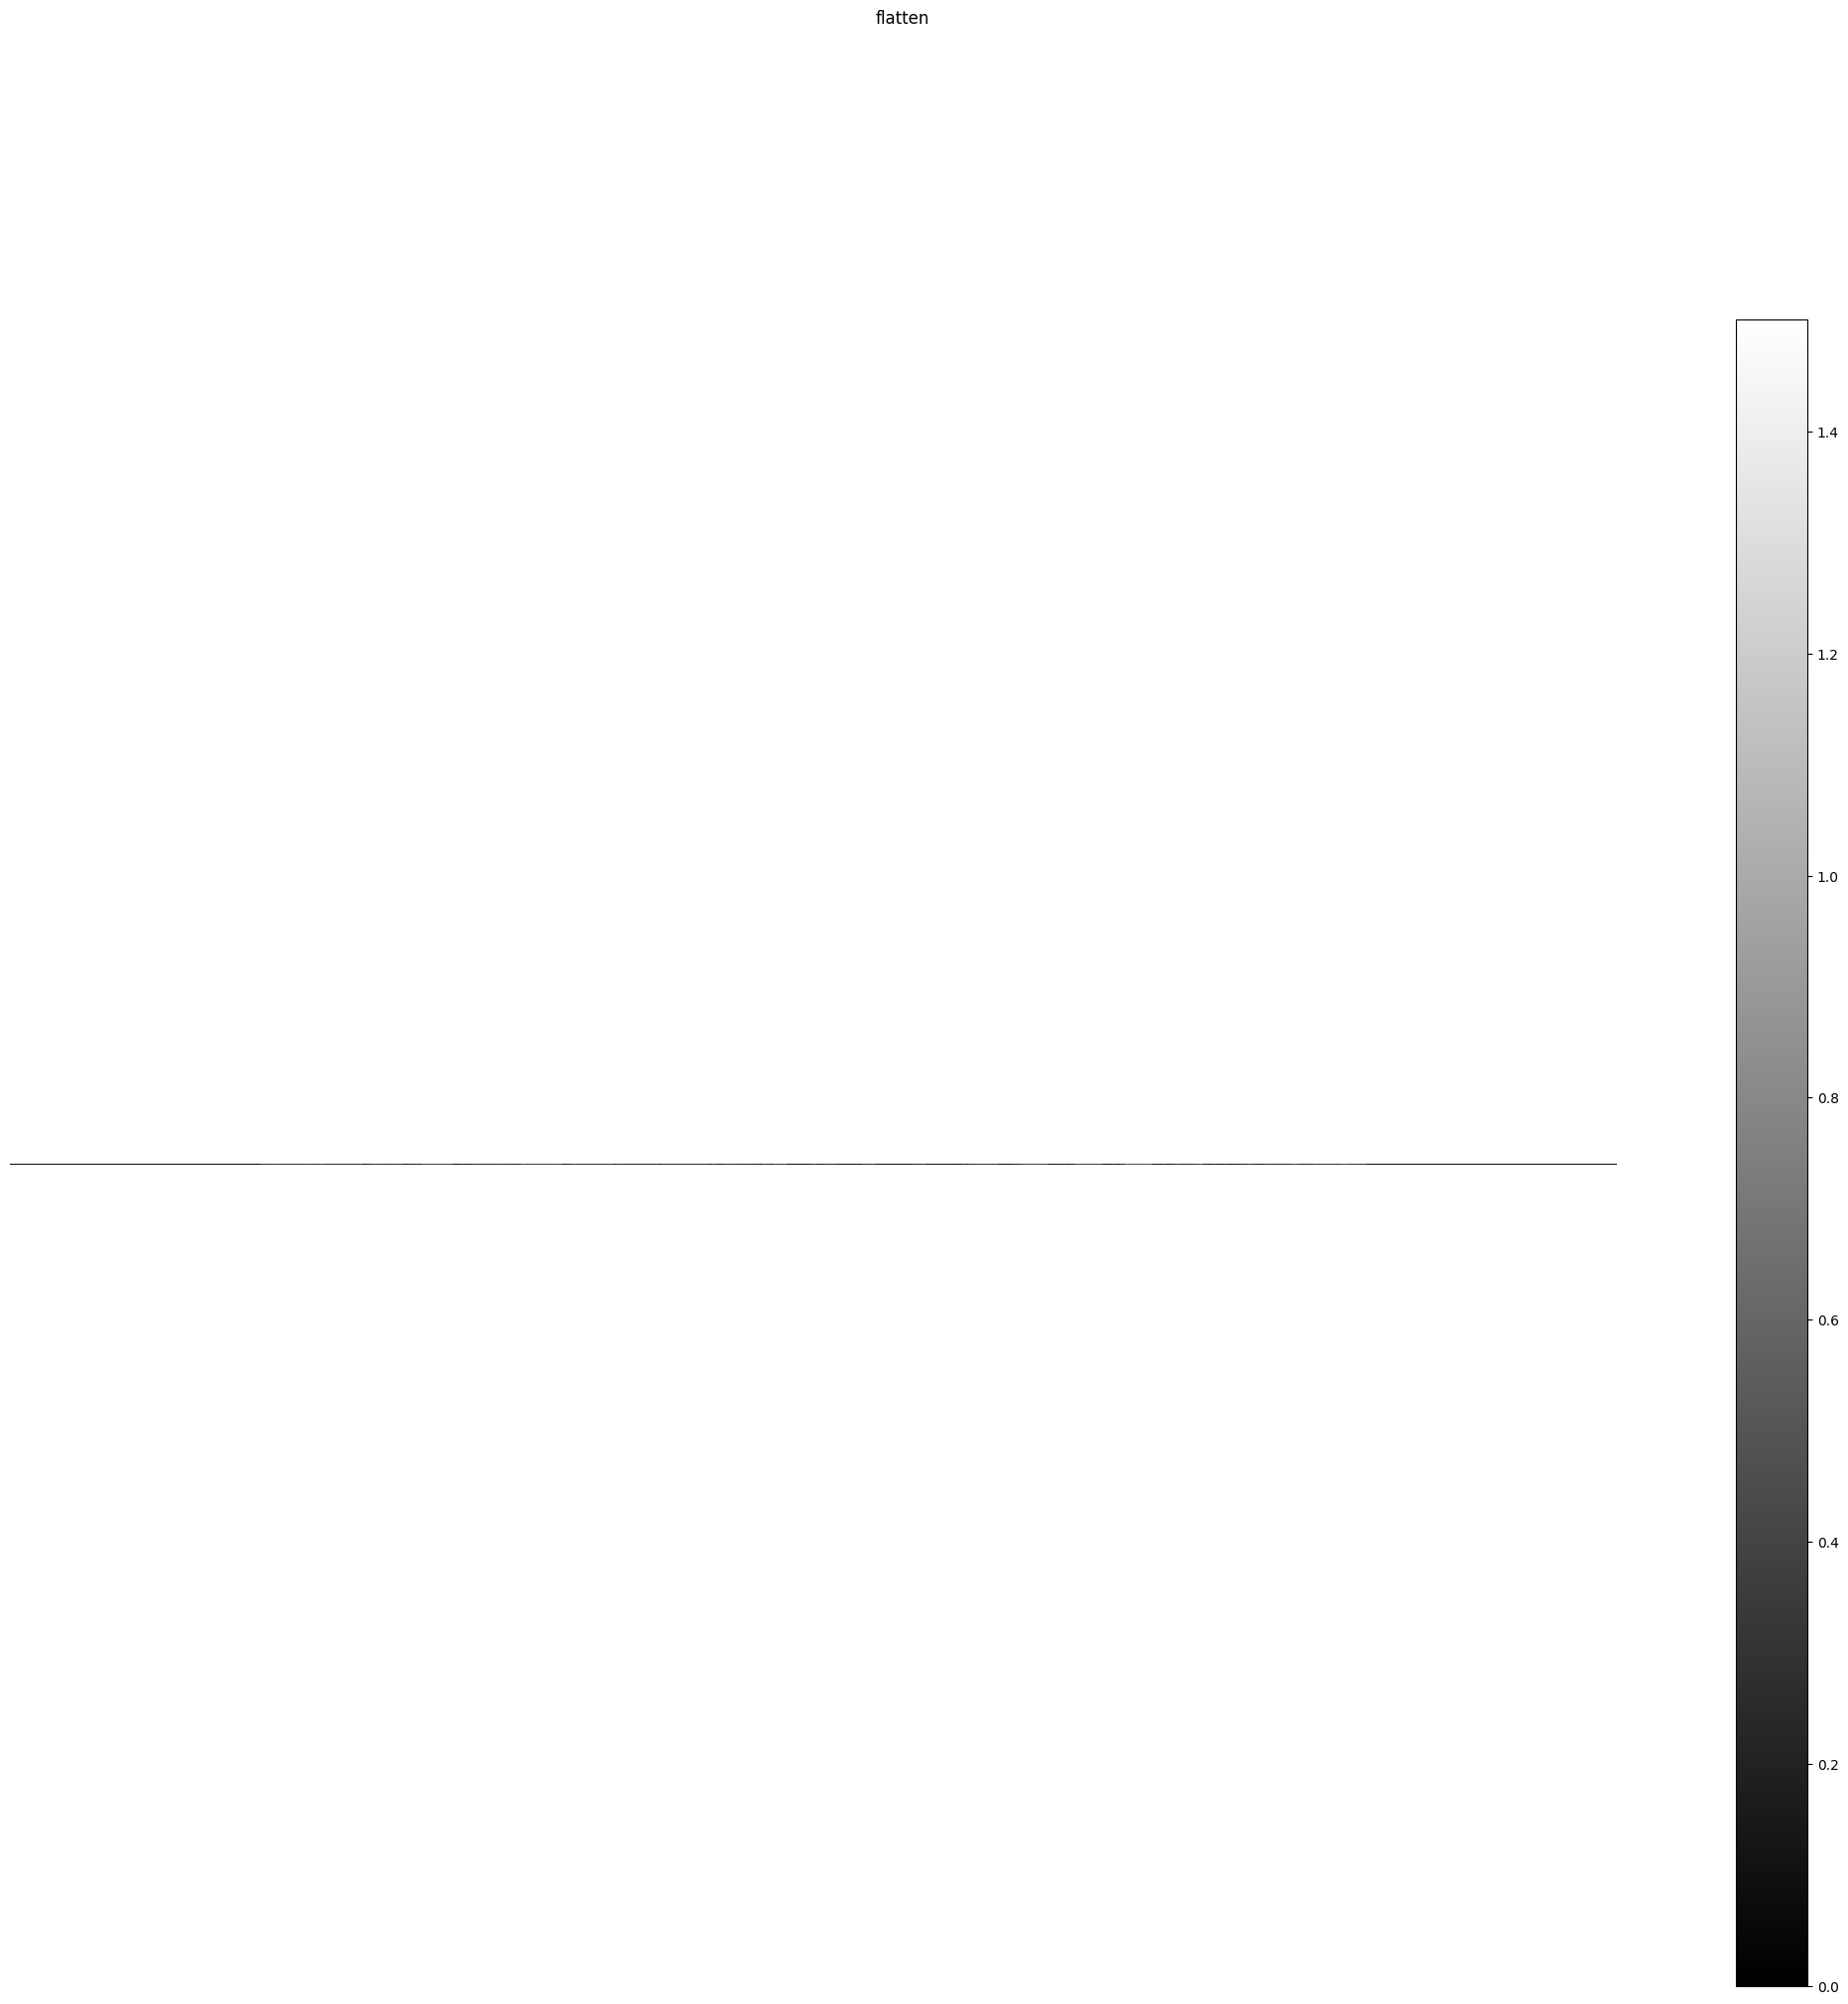

dense (1, 5) 


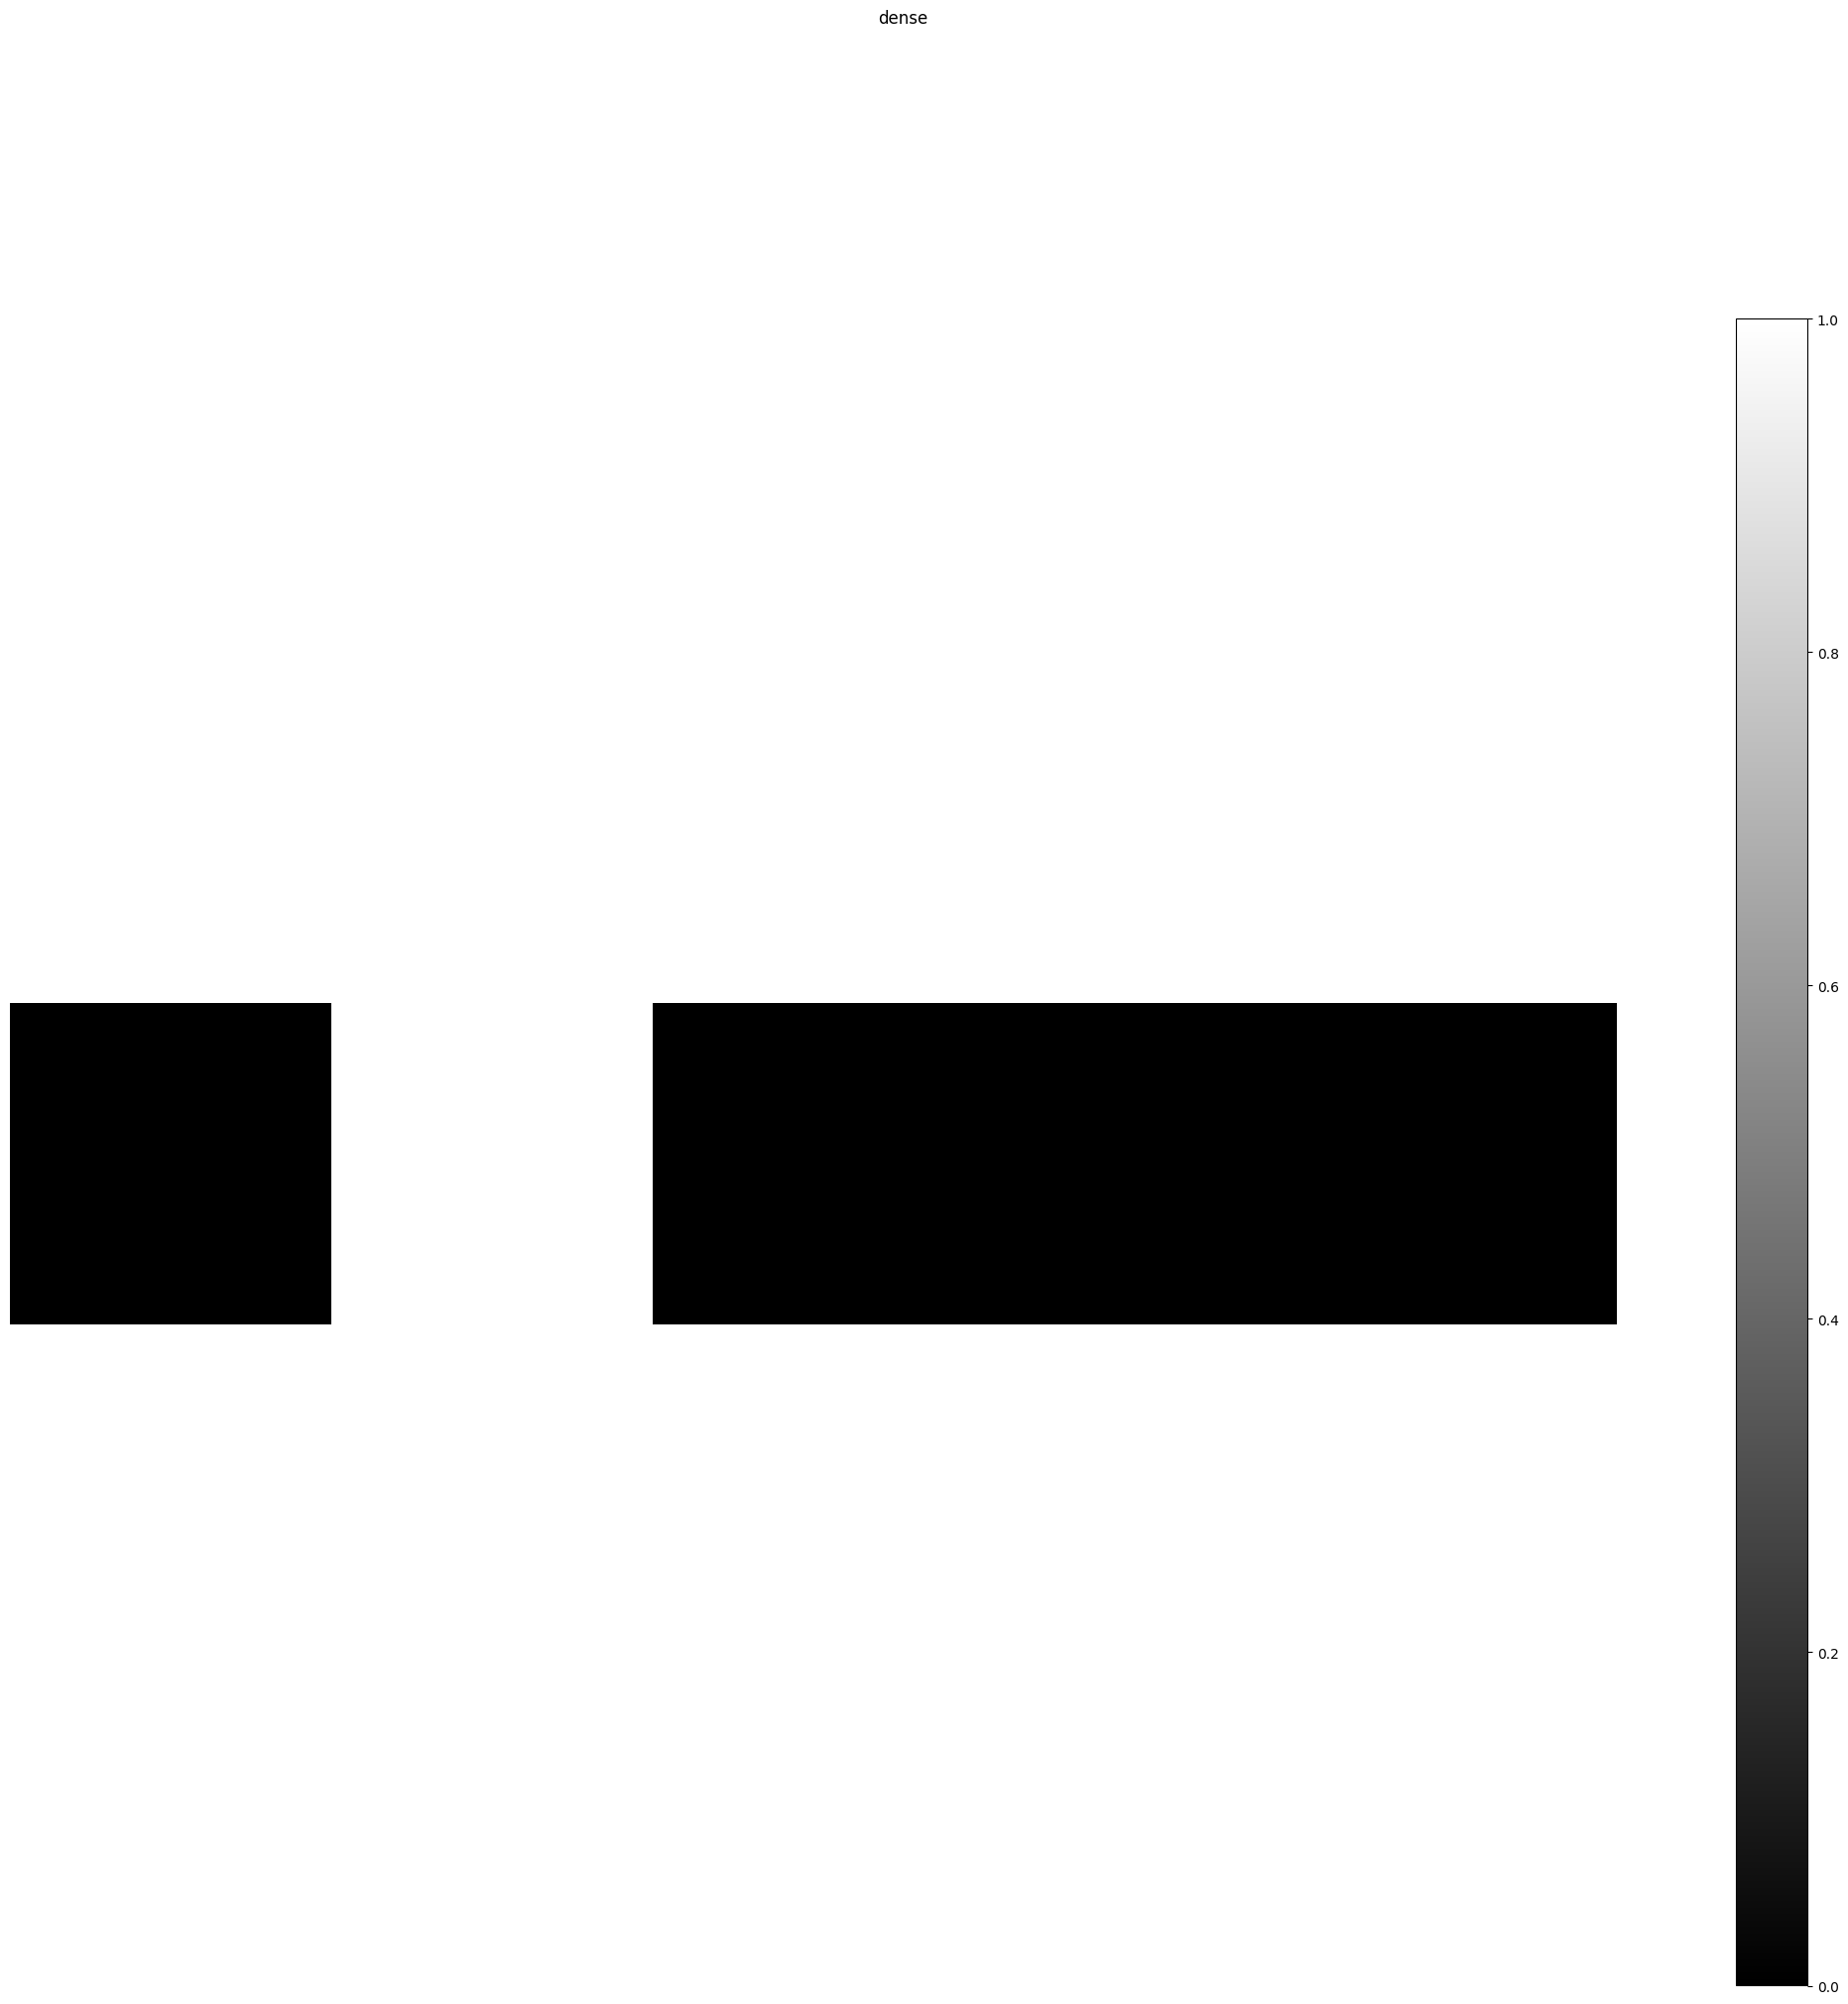

In [ ]:
#take an example from the train dataset
train_example = train_dataset.unbatch().take(1) #unbatche the train dataste than take 1 sample observation at random
for image, label in train_example: #then to access the tensor for the image and the tensor for the label we have to iterate through
  image_sample = image
  label_sample = label

image_sample = tf.expand_dims(image_sample, 0) #chnage its shape from (128,128,3) to (1,128,128,3) since this is the shape the model expects (since it was trained on a batched dataset and that first dimension represents the batch size)

# =============================================
# Keract visualizations
# =============================================
from keract import get_activations, display_activations

# enter sampel input, ample label and the model name
keract_inputs = image_sample
keract_targets = label_sample
keract_model = model_simple

#run as is
activations = get_activations(keract_model, keract_inputs)
display_activations(activations, cmap="gray", save=False)

#### Generating layer activation heatmaps


conv2d_input (1, 128, 128, 3) 


AttributeError: ignored

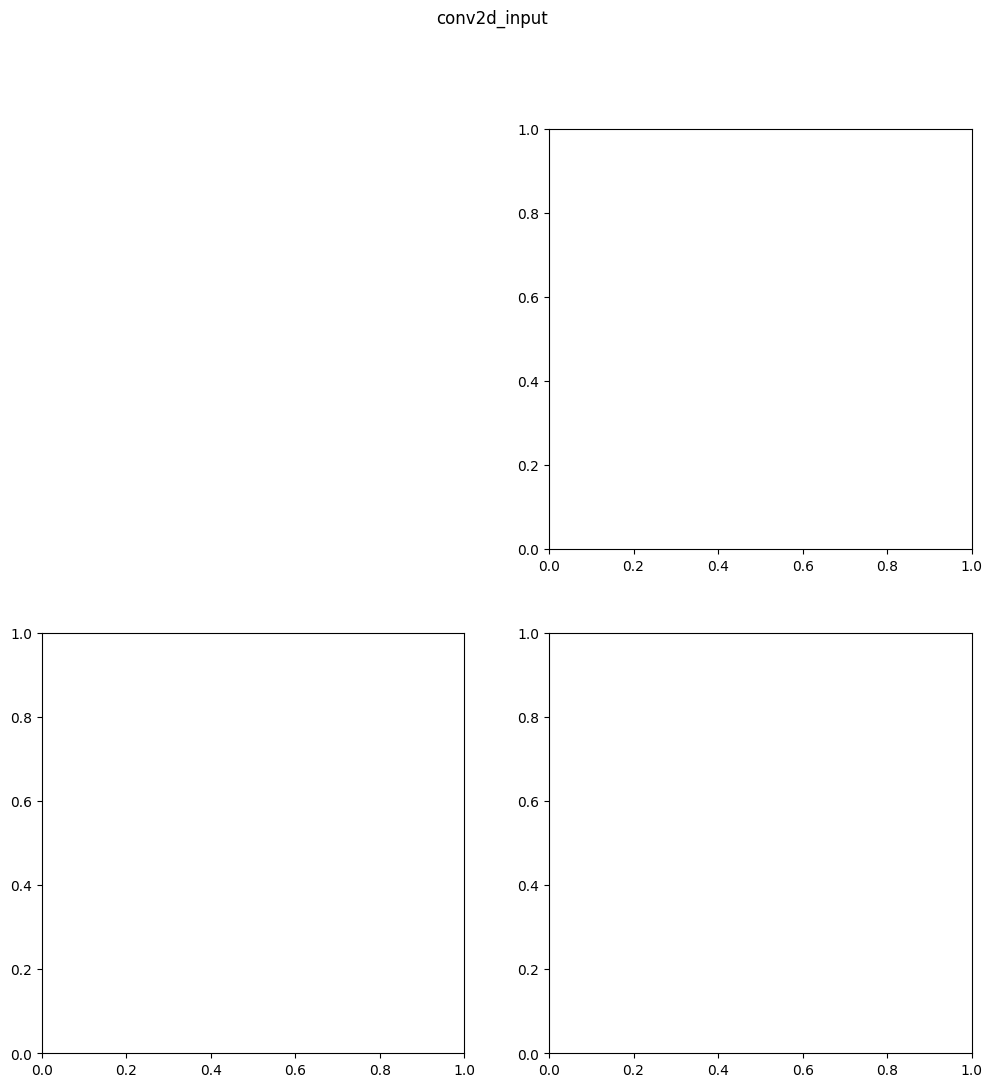

In [ ]:
#required to not raise an reshape error for the earger tensor
import tensorflow.python.ops.numpy_ops.np_config as np_config
np_config.enable_numpy_behavior()

#take an example from the train dataset
train_example = train_dataset.unbatch().take(1) #unbatche the train dataste than take 1 sample observation at random
for image, label in train_example: #then to access the tensor for the image and the tensor for the label we have to iterate through
  image_sample = image
  label_sample = label

image_sample_array = image_sample.numpy() #numpy version of the image sample
image_sample = tf.expand_dims(image_sample, 0) #chnage its shape from (128,128,3) to (1,128,128,3) since this is the shape the model expects (since it was trained on a batched dataset and that first dimension represents the batch size)

# =============================================
# Keract visualizations
# =============================================
from keract import get_activations, display_heatmaps

# enter sampel input, ample label and the model name
keract_inputs = image_sample
keract_targets = label_sample
keract_model = model_simple

#run as is
activations = get_activations(keract_model, keract_inputs)
display_heatmaps(activations, keract_inputs, save=False)